# Example: Deep learning
------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/) using [scikeras](https://www.adriangb.com/scikeras/refs/heads/master/index.html).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow import get_logger
get_logger().setLevel('ERROR')

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from atom import ATOMClassifier, ATOMModel
from sklearn.preprocessing import FunctionTransformer
from optuna.pruners import PatientPruner
from optuna.distributions import CategoricalDistribution, IntDistribution

from scikeras.wrappers import KerasClassifier
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout

In [2]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten data to follow sklearn's API (2d input)
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

data = (X_train, y_train), (X_test, y_test)

In [3]:
# Create the convolutional neural network
class ConvNN(KerasClassifier):
    """Convolutional neural network model."""

    def __repr__(self):
        return f"ConvCNN(epochs={self.epochs}, batch_size={self.batch_size})"
    
    @property
    def feature_encoder(self):
        """Convert the 2d input to the image's format (len(X), 28, 28, 1)."""
        return FunctionTransformer(
            func=lambda X: X.reshape(X.shape[0], 28, 28, 1),
        )

    @staticmethod
    def _keras_build_fn(**kwargs):
        """Create the model's architecture."""
        model = Sequential()
        model.add(
            Conv2D(
                filters=8,
                kernel_size=3,
                activation="relu",
                input_shape=(28, 28, 1),
            )
        )
        model.add(Conv2D(filters=4, kernel_size=5, activation="relu"))
        model.add(Flatten())
        model.add(Dense(units=10, activation="softmax"))
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
        )

        return model

In [4]:
# Convert the model to an ATOM model
model = ATOMModel(
    estimator=ConvNN(verbose=0),
    acronym="CNN",
    needs_scaling=True,  # Applies automated feature scaling before fitting
    validation="epochs",  # Applies in-training validation on parameter epochs
)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, verbose=2, random_state=1)

<< ================== ATOM ================== >>

Configuration ==================== >>
Algorithm task: Multiclass classification.

Dataset stats ==================== >>
Shape: (7000, 785)
Train set size: 6000
Test set size: 1000
-------------------------------------
Memory: 5.54 MB
Scaled: False
Outlier values: 41839 (0.9%)



In [6]:
# Like any other model, we can define custom distributions for hyperparameter tuning
atom.run(
    models=model,
    metric="f1_weighted",
    n_trials=12,
    ht_params={
        "distributions": {
            "epochs": IntDistribution(2, 10),
            "batch_size": CategoricalDistribution([128, 256, 512]),
        },
    }
)


Training ========================= >>
Models: CNN
Metric: f1_weighted


Running hyperparameter tuning for ConvNN...
| trial |  epochs | batch_size | f1_weighted | best_f1_weighted | time_trial | time_ht |    state |
| ----- | ------- | ---------- | ----------- | ---------------- | ---------- | ------- | -------- |
| 0     |       5 |        128 |      0.9117 |           0.9117 |     6.084s |  6.084s | COMPLETE |
| 1     |       3 |        512 |      0.8639 |           0.9117 |     2.703s |  8.787s | COMPLETE |
| 2     |       5 |        512 |      0.9124 |           0.9124 |     3.391s | 12.178s | COMPLETE |
| 3     |       3 |        128 |      0.9133 |           0.9133 |     2.819s | 14.997s | COMPLETE |
| 4     |       5 |        128 |      0.9117 |           0.9133 |     0.686s | 15.683s | COMPLETE |
| 5     |       9 |        128 |       0.931 |            0.931 |     6.333s | 22.016s | COMPLETE |
| 6     |       9 |        128 |       0.931 |            0.931 |     0.687s | 22.7

## Analyze the results

In [7]:
atom.cnn.trials

epochs  batch_size                           estimator  f1_weighted  \
trial                                                                        
0           5         128   ConvCNN(epochs=5, batch_size=128)     0.911690   
1           3         512   ConvCNN(epochs=3, batch_size=512)     0.863904   
2           5         512   ConvCNN(epochs=5, batch_size=512)     0.912432   
3           3         128   ConvCNN(epochs=3, batch_size=128)     0.913311   
4           5         128   ConvCNN(epochs=5, batch_size=128)     0.911690   
5           9         128   ConvCNN(epochs=9, batch_size=128)     0.930984   
6           9         128   ConvCNN(epochs=9, batch_size=128)     0.930984   
7           3         128   ConvCNN(epochs=3, batch_size=128)     0.913311   
8          10         256  ConvCNN(epochs=10, batch_size=256)     0.811711   
9           8         128   ConvCNN(epochs=8, batch_size=128)     0.935933   
10          7         256   ConvCNN(epochs=7, batch_size=256)     0.816620   
11          8         128   ConvCNN(epochs=8, batch_size=128)     0.935933   

       best_f1_weighted  time_trial    time_ht     state  
trial                                                     
0              0.935933    6.083710   6.083710  COMPLETE  
1              0.935933    2.703036   8.786746  COMPLETE  
2              0.935933    3.391315  12.178061  COMPLETE  
3              0.935933    2.818841  14.996902  COMPLETE  
4              0.935933    0.685945  15.682847  COMPLETE  
5              0.935933    6.333406  22.016253  COMPLETE  
6              0.935933    0.687231  22.703484  COMPLETE  
7              0.935933    0.719169  23.422653  COMPLETE  
8              0.935933    2.337121  25.759774    PRUNED  
9              0.935933    5.401685  31.161459  COMPLETE  
10             0.935933    2.030597  33.192056    PRUNED  
11             0.935933    0.763396  33.955452  COMPLETE

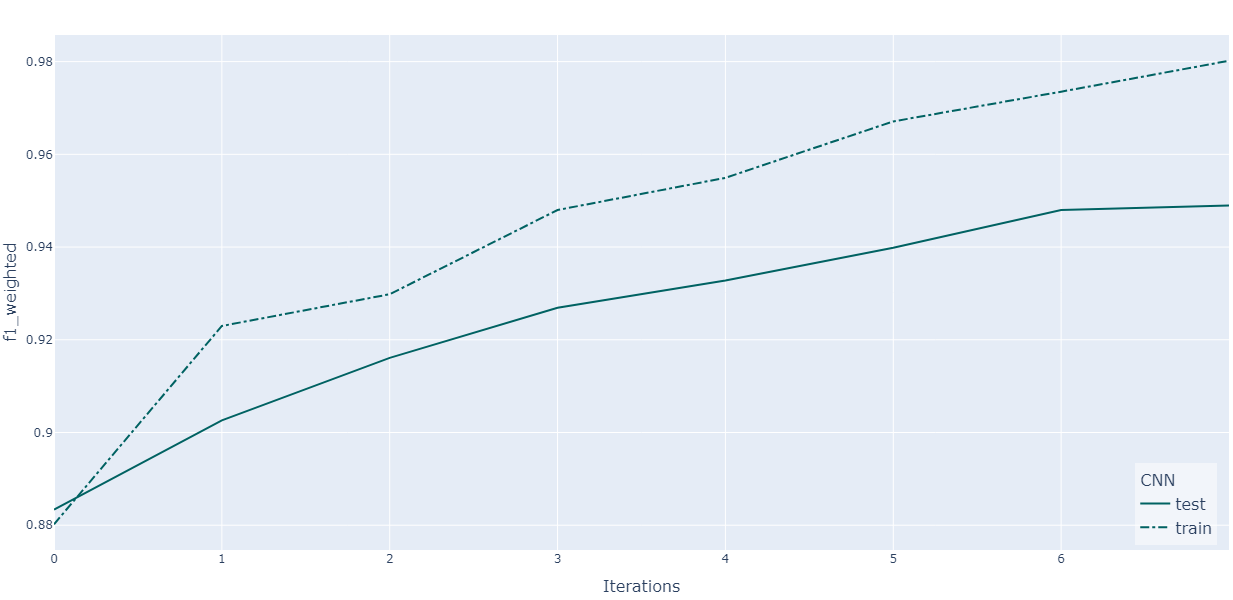

In [8]:
atom.plot_evals(dataset="test+train")

In [9]:
# Use the prediction methods like any other model
atom.cnn.predict_proba(X_train)

0             1             2             3             4  \
0      1.307044e-05  1.568995e-08  1.577362e-07  5.547323e-01  6.615952e-13   
1      9.999791e-01  1.273131e-13  1.069871e-05  5.397324e-06  4.301729e-11   
2      3.484103e-08  3.393684e-11  5.203010e-06  1.571766e-02  9.815357e-01   
3      8.112654e-06  9.863332e-01  1.030537e-02  1.218725e-03  1.270328e-04   
4      1.001391e-07  5.152165e-08  4.582921e-08  1.374094e-06  3.282512e-04   
...             ...           ...           ...           ...           ...   
59995  1.752743e-07  2.726712e-08  2.334283e-05  6.834044e-04  1.447640e-09   
59996  3.995948e-08  1.769749e-11  3.773316e-05  9.993407e-01  5.596321e-11   
59997  2.610836e-09  1.053394e-08  2.185990e-11  3.885221e-06  1.124057e-07   
59998  2.247100e-05  4.087218e-10  1.537897e-05  3.423449e-07  8.800313e-05   
59999  2.367755e-03  1.089451e-06  7.798470e-04  1.089100e-04  4.971863e-07   

                  5             6             7             8             9  
0      4.448984e-01  2.237937e-09  7.357283e-05  1.431092e-06  2.809444e-04  
1      3.595555e-06  1.475882e-07  7.560189e-07  1.113460e-07  1.253444e-07  
2      1.054429e-07  3.349228e-09  1.937806e-03  1.708786e-09  8.035503e-04  
3      1.164421e-04  5.795559e-06  6.505852e-04  1.232883e-03  1.917987e-06  
4      1.094107e-05  3.585770e-08  5.622397e-04  2.960541e-05  9.990675e-01  
...             ...           ...           ...           ...           ...  
59995  2.075632e-04  8.177348e-10  2.342909e-09  9.990804e-01  5.114372e-06  
59996  3.196757e-05  5.598433e-12  1.259224e-09  5.863165e-04  3.123161e-06  
59997  9.999393e-01  3.431801e-09  1.887737e-10  1.365938e-05  4.290161e-05  
59998  4.501368e-04  9.994226e-01  2.936092e-09  1.103918e-06  4.242235e-10  
59999  9.902807e-02  1.008111e-06  2.136125e-06  8.915027e-01  6.208047e-03  

[60000 rows x 10 columns]

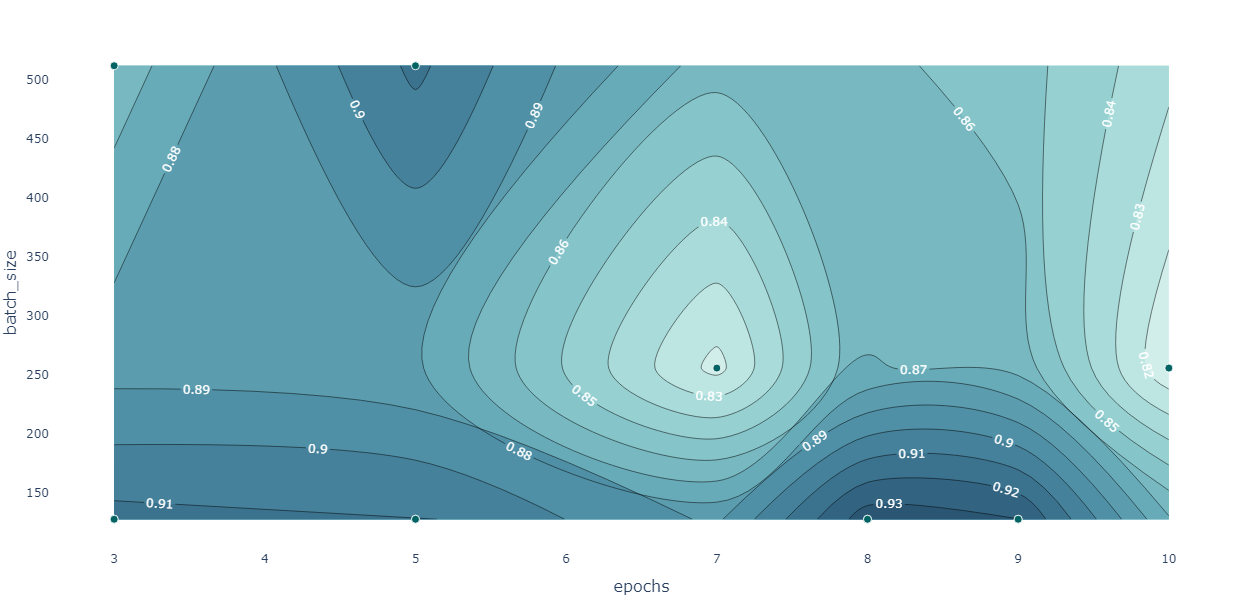

In [10]:
# Or make plots...
atom.cnn.plot_hyperparameters()

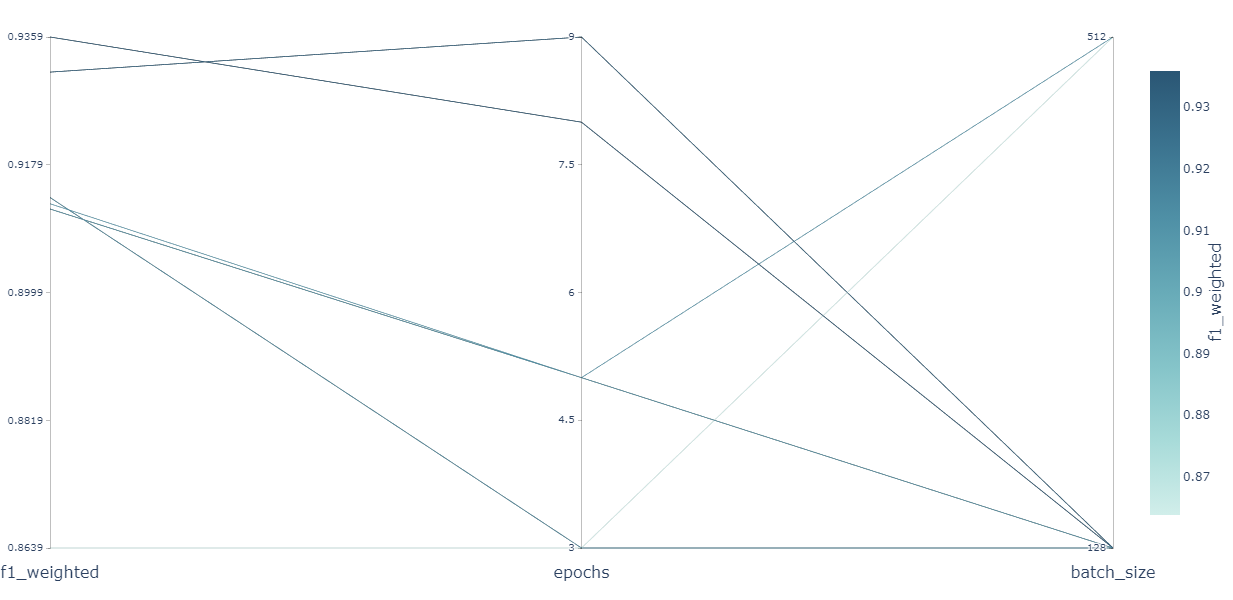

In [11]:
atom.plot_parallel_coordinate()